# Installing dependencies

In [0]:
!pip install -q -U tqdm
!pip install -q -U gensim
!pip install -q -U spacymoji

In [0]:
%%capture
import spacy

SPACY_CORE_MODEL = 'es_core_news_md'
spacy.cli.download(SPACY_CORE_MODEL)

# Mounting drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/My Drive/Sentime/data

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Sentime/data


# Load datasets

In [0]:
import os
import pandas as pd
import numpy as np

from pathlib import Path

DATA_PATH = "/content/gdrive/My Drive/Sentime/data"
pretrained_w2v_path = Path(os.path.join(DATA_PATH, "embeddings", "SBW-vectors-300-min5.bin.gz"))
pretrained_w2v_pytorch_path = Path(os.path.join(DATA_PATH, "embeddings", "w2v-300.txt"))


train_data_path = Path(os.path.join(DATA_PATH, "train"))
val_data_path = Path(os.path.join(DATA_PATH, "validation"))
test_data_path = Path(os.path.join(DATA_PATH, "test"))
model_dir = Path(os.path.join(DATA_PATH, "model"))

def read_data(data_dir):
    df = pd.read_csv(data_dir/'data.csv')
    idx_mixed = df[df.sentiment == 'MIXED'].index
    df.drop(idx_mixed, axis = 0, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df


train_df = read_data(train_data_path)
val_df = read_data(val_data_path)
test_df = read_data(test_data_path)

In [0]:
train_df.head()

,tweet,sentiment
0,cuando tu lugar de trabajo también se conviert...,NEUTRAL
1,adivinen a quién me voy a llevar a pasear por ...,NEUTRAL
2,rap en huitoto lengua de la amazonía en letici...,NEUTRAL
3,extrañare esto,NEGATIVE
4,y la verdad es que no me quiero de casa :(,NEGATIVE


In [0]:
train_df.tweet.isna().sum()

1

In [0]:
train_df.dropna(inplace=True) # drop nan

In [0]:
val_df.head()

,tweet,sentiment
0,disfruta de consejos útiles recetas y guías pa...,POSITIVE
1,when casper mágico said “tú me rompiste el cor...,POSITIVE
2,quinta llamada de 10 minutos esperamdo a q el ...,NEGATIVE
3,en san andrés propone al gobierno fortalecer e...,NEUTRAL
4,durante el periodo de aislamiento domiciliario...,NEUTRAL


In [0]:
val_df.tweet.isna().sum()

1

In [0]:
val_df.dropna(inplace=True) # drop nan

In [0]:
test_df.head()

,tweet,sentiment
0,unidos acabarán con bogotá,NEUTRAL
1,claudia lópez será investigada por la fiscalía...,NEGATIVE
2,y después del festivo el a partir del lunes 4 ...,NEUTRAL
3,mas claro y real no puede ser he aprendido mas...,POSITIVE
4,lo que es pa uno es pa uno así hayan mil perso...,NEGATIVE


In [0]:
test_df.tweet.isna().sum()

1

In [0]:
test_df.dropna(inplace=True) # drop nan

# Visualize classes proportions

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

def plot_classes_proportion(df, title="train classes proportion"):
    plot_data = df["sentiment"].value_counts()
    x = plot_data.index.values
    y = plot_data.values

    
    plt.figure(figsize=(8,5))
    fig = sns.barplot(x=x, y=y, orient="v", palette="hls")

    plt.ylabel("num_tweets")
    plt.title(title)
    plt.tight_layout()
    plt.show()

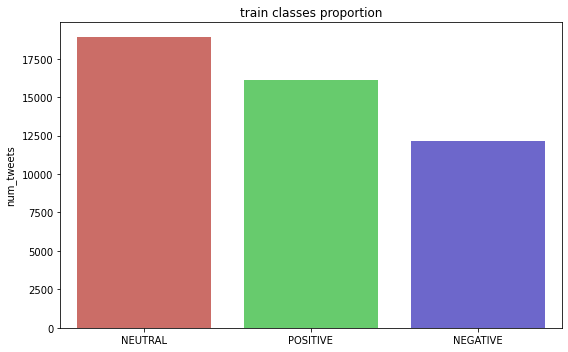

In [0]:
plot_classes_proportion(train_df)

Our data is not balanced, let's balance

## Balance the dataset

In [0]:
from sklearn.utils import resample

def balance_dataset(df, order):
    class_distribution = df["sentiment"].value_counts()
    minority_shape = df[df.sentiment == order[0]].shape[0]

    df_list = [df[df.sentiment == order[0]]]
    for cls in order[1:]:
        df_temp = df[df.sentiment == cls]
        df_down_sample = resample(df_temp, replace=False, n_samples = minority_shape,
                                   random_state=123)
        df_list.append(df_down_sample)

    df_downsampled = pd.concat(df_list)
    # shuffle
    df_downsampled = df_downsampled.sample(frac = 1)
    df_downsampled.reset_index(drop=True, inplace=True)
    return df_downsampled

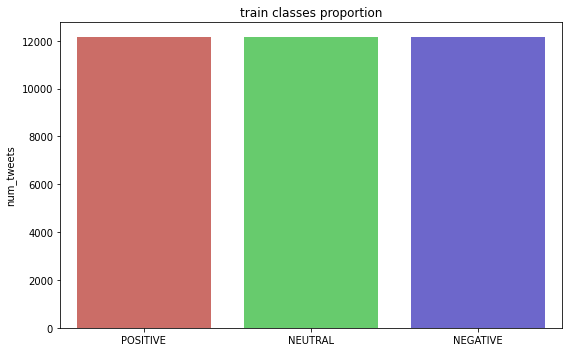

In [0]:
ORDER = ["NEGATIVE", "POSITIVE", "NEUTRAL"]
train_df = balance_dataset(train_df, order=ORDER)

plot_classes_proportion(train_df)

In [0]:
train_df.head()

,tweet,sentiment
0,besos y caricias lo que yo necesitaba,POSITIVE
1,¡último reporte!asciende cifra a 108 casos pos...,NEUTRAL
2,y dentro de la lógica de nuestra humanidad nos...,NEGATIVE
3,gracias comuna su cariño y aplausos son la sat...,POSITIVE
4,amé tu discurso que mejor escenario para canta...,POSITIVE


## Preprocess data

In [0]:
from tqdm.notebook import tqdm
tqdm.pandas(desc="Preprocess data")

In [0]:
# Import Spacy:
import spacy
from spacymoji import Emoji

nlp = spacy.load(SPACY_CORE_MODEL)
# Add emoji detection
emoji = Emoji(nlp, merge_spans=False)
nlp.add_pipe(emoji, first=True)

def tokenizer_tweet(tweet):
    vector = nlp(tweet)
    # Remove all punctuation marks
    vector = [token for token in vector if not token.is_punct]
    # Remove numbers or amount representation
    vector = [token for token in vector if not token.like_num]
    # Remove emoji
    vector = [token for token in vector if not token._.is_emoji]
    # Get text and lower
    vector = [token.text.lower() for token in vector]
    
    return vector

In [0]:
train_df["tweet_clean"] = train_df["tweet"].progress_apply(lambda x: tokenizer_tweet(x))

In [0]:
val_df["tweet_clean"] = val_df["tweet"].progress_apply(lambda x: tokenizer_tweet(x))

In [0]:
test_df["tweet_clean"] = test_df["tweet"].progress_apply(lambda x: tokenizer_tweet(x))

In [0]:
def get_empty_clean_tweets(df):
    """
    Get index with len(tweet_clean) equal 0

    Args:
        df -- pandas dataframe
    Return:
        idxs -- indexes
    """
    idxs = []
    for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
        if len(row.tweet_clean) == 0:
            idxs.append(idx)
    return idxs

In [0]:
train_idxs = get_empty_clean_tweets(train_df)

In [0]:
train_df.loc[train_idxs]

,tweet,sentiment,tweet_clean
29669,&,NEUTRAL,[]
35089,31 1 2015:,NEUTRAL,[]


In [0]:
val_idxs = get_empty_clean_tweets(val_df)

In [0]:
val_df.loc[val_idxs]

,tweet,sentiment,tweet_clean
122,cero,NEGATIVE,[]


In [0]:
test_idxs = get_empty_clean_tweets(test_df)

In [0]:
test_df.loc[test_idxs]

,tweet,sentiment,tweet_clean
39,cero,NEGATIVE,[]
155,1 3,NEUTRAL,[]
2954,),NEUTRAL,[]


In [0]:
def drop_empty_tweet_clean(df, idxs):
    """
    Drop empty inplace

    Args:
        df -- pandas dataframe
        idxs -- list of indexes where tweet_clean is empty
    Return:
        df
    """
    df.drop(idxs, axis=0, inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [0]:
train_df = drop_empty_tweet_clean(train_df, train_idxs)
val_df = drop_empty_tweet_clean(val_df, val_idxs)
test_df = drop_empty_tweet_clean(test_df, test_idxs)

# Save to json 

In [0]:
import json

clean_data_path = "/content/gdrive/My Drive/Sentime/data/clean_data"

with open(f"{clean_data_path}/train.json", "w") as f:
    for i, row in tqdm(train_df[["sentiment", "tweet_clean"]].iterrows(), total=train_df.shape[0]):
        data_json = json.dumps({"text": row.tweet_clean, "label": row.sentiment}, ensure_ascii=False)
        f.write(data_json)
        f.write("\n")
        
with open(f"{clean_data_path}/val.json", "w") as f:
    for i, row in tqdm(val_df[["sentiment", "tweet_clean"]].iterrows(), total=val_df.shape[0]):
        data_json = json.dumps({"text": row.tweet_clean, "label": row.sentiment}, ensure_ascii=False)
        f.write(data_json)
        f.write("\n")
        
with open(f"{clean_data_path}/test.json", "w") as f:
    for i, row in tqdm(test_df[["sentiment", "tweet_clean"]].iterrows(), total=test_df.shape[0]):
        data_json = json.dumps({"text": row.tweet_clean, "label": row.sentiment}, ensure_ascii=False)
        f.write(data_json)
        f.write("\n")

# Create Torchtext Dataset

In [0]:
import torch
from torchtext import data
from torchtext import datasets

In [0]:
TEXT = data.Field(include_lengths = True)
LABEL = data.LabelField(dtype = torch.long)

In [0]:
fields = {'text': ('text', TEXT), 'label': ('label', LABEL)}

In [0]:
train_data, valid_data, test_data = data.TabularDataset.splits(
                            path=clean_data_path,
                            train = 'train.json',
                            validation= 'val.json',
                            test = 'test.json',
                            format = 'json',
                            fields = fields
)

In [0]:
print(vars(train_data[0]))
print(vars(valid_data[0]))
print(vars(test_data[0]))

{'text': ['ya', 'quiero', 'volver', 'a', 'casa', 'para', 'ver', 'sonreír', 'a', 'mi', 'mamá'], 'label': 'POSITIVE'}
{'text': ['disfruta', 'de', 'consejos', 'útiles', 'recetas', 'y', 'guías', 'para', 'fomentar', 'en', 'casa', 'previniendo', 'accidentes', 'en', 'tu', 'hogar', 'resolviendo', 'conflictos', 'y', 'llegando', 'acuerdos', 'es', 'posible', 'junto', 'a', 'los', 'niños', 'niñas', 'y', 'adolescentes', 'ingresa', 'a', 'y'], 'label': 'POSITIVE'}
{'text': ['unidos', 'acabarán', 'con', 'bogotá'], 'label': 'NEUTRAL'}


# Load pretrained word 2 vec

In [0]:
from torchtext.vocab import Vectors
from gensim.models import KeyedVectors

import logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s", level=logging.INFO)
logger = logging.getLogger()

In [0]:
w2v_vectors = Vectors(name="embeddings/w2v-300.txt", cache="embeddings")

2020-06-01 01:26:23,767 : INFO : Loading vectors from embeddings/w2v-300.txt.pt


In [0]:
from scipy import spatial
1 - spatial.distance.cosine(w2v_vectors["perro"], w2v_vectors["perros"]) # Expected output 0.7533276677131653

0.7533276677131653

# Build Vocab for each TorchText Dataset

In [0]:
import random

SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [0]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = w2v_vectors, 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

In [0]:
vars(LABEL.vocab)

{'freqs': Counter({'NEGATIVE': 12158, 'NEUTRAL': 12156, 'POSITIVE': 12158}),
 'itos': ['NEGATIVE', 'POSITIVE', 'NEUTRAL'],
 'stoi': defaultdict(<function torchtext.vocab._default_unk_index>,
             {'NEGATIVE': 0, 'NEUTRAL': 2, 'POSITIVE': 1}),
 'vectors': None}

In [0]:
vars(TEXT.vocab)

{'freqs': Counter({'ya': 1391,
          'quiero': 815,
          'volver': 133,
          'a': 12150,
          'casa': 491,
          'para': 4885,
          'ver': 526,
          'sonreír': 23,
          'mi': 4082,
          'mamá': 178,
          'estamos': 402,
          'actualmente': 12,
          'en': 13393,
          'la': 16197,
          'secretaria': 23,
          'de': 25775,
          'salud': 319,
          'd': 513,
          'riohacha': 105,
          'como': 1991,
          'punto': 77,
          'principal': 29,
          'parq': 2,
          'entrerrios': 1,
          'vida': 1279,
          'mercad': 1,
          'nuevo': 409,
          'sera': 75,
          'que': 14671,
          'soy': 475,
          'unica': 10,
          'le': 1485,
          'encantan': 11,
          'las': 4064,
          'canciones': 50,
          'rebelde': 3,
          'canta': 17,
          'hay': 956,
          'riqueza': 24,
          'más': 2091,
          'grande': 217,
          '

# Iterator

In [0]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch = True,
    device = device)

In [0]:
print(vars(train_iterator))

{'batch_size': 64, 'train': True, 'dataset': <torchtext.data.dataset.TabularDataset object at 0x7f11008f12b0>, 'batch_size_fn': None, 'iterations': 0, 'repeat': False, 'shuffle': True, 'sort': False, 'sort_within_batch': True, 'sort_key': <function <lambda> at 0x7f10fb1a8b70>, 'device': device(type='cpu'), 'random_shuffler': <torchtext.data.utils.RandomShuffler object at 0x7f10f50ffd30>, '_iterations_this_epoch': 0, '_random_state_this_epoch': None, '_restored_from_state': False}


# Model

In [0]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        embedded = self.dropout(self.embedding(text))
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        return self.fc(hidden)

## Model configurations

In [0]:
import torchvision.models
import hiddenlayer as hl

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 3
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = Net(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)
print(model)

Net(
  (embedding): Embedding(25002, 300, padding_idx=1)
  (rnn): LSTM(300, 256, num_layers=2, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


## Model Parameters

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 10,221,883 trainable parameters


## Load to model Pretrained Parameters

In [0]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)
model.embedding.weight.data.copy_(pretrained_embeddings)

torch.Size([25002, 300])


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0799,  0.0305,  0.0537,  ..., -0.3450, -0.0132,  0.1687],
        ...,
        [ 0.0729,  0.2928,  0.0663,  ..., -0.4808, -0.1806, -0.1073],
        [-0.1743, -0.0160,  0.0622,  ...,  0.0713,  0.2028, -0.0503],
        [ 0.1827,  0.0930,  0.1014,  ..., -0.1861, -0.0303, -0.0336]])

## Initialize to zero the especial tokens "unk" y "pad"

In [0]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0799,  0.0305,  0.0537,  ..., -0.3450, -0.0132,  0.1687],
        ...,
        [ 0.0729,  0.2928,  0.0663,  ..., -0.4808, -0.1806, -0.1073],
        [-0.1743, -0.0160,  0.0622,  ...,  0.0713,  0.2028, -0.0503],
        [ 0.1827,  0.0930,  0.1014,  ..., -0.1861, -0.0303, -0.0336]])


## Training

### Training configurations

In [0]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
model = model.to(device)
criterion = criterion.to(device)

### Utility functions

In [0]:
# Get categorical accuracy from predictions
def categorical_accuracy(preds, y):
    #round predictions to the closest integer
    _, rounded_preds = torch.max(preds, 1)
    correct = (rounded_preds == y).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

In [0]:
# Train method
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = categorical_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
# Evaluate
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = categorical_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [0]:
# Nice print for time
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## Main loop for training

In [0]:
N_EPOCHS = 5

losses = {"train": [], "val": []}
accuracies = {"train": [], "val": []}

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    # Start time
    start_time = time.time()
    
    # Train model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    # Validate model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    # Save the losses of each phase
    losses["train"].append(train_loss)
    losses["val"].append(valid_loss)

    # Save the accuracies of each phase
    accuracies["train"].append(train_acc)
    accuracies["val"].append(valid_acc)

    # End time
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), './model/last_model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 5m 59s
	Train Loss: 0.711 | Train Acc: 69.30%
	 Val. Loss: 0.615 |  Val. Acc: 74.72%
Epoch: 02 | Epoch Time: 6m 12s
	Train Loss: 0.533 | Train Acc: 78.59%
	 Val. Loss: 0.560 |  Val. Acc: 76.85%
Epoch: 03 | Epoch Time: 6m 25s
	Train Loss: 0.431 | Train Acc: 83.22%
	 Val. Loss: 0.592 |  Val. Acc: 76.87%
Epoch: 04 | Epoch Time: 6m 23s
	Train Loss: 0.350 | Train Acc: 86.65%
	 Val. Loss: 0.629 |  Val. Acc: 75.83%
Epoch: 05 | Epoch Time: 6m 21s
	Train Loss: 0.282 | Train Acc: 89.39%
	 Val. Loss: 0.690 |  Val. Acc: 75.52%


## Testing 

In [0]:
model.load_state_dict(torch.load('model/local_model.pt', map_location=torch.device('cpu')))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.546 | Test Acc: 78.04%


In [0]:
val_loss, val_acc = evaluate(model, valid_iterator, criterion)

print(f'Val Loss: {val_loss:.3f} | Val Acc: {val_acc*100:.2f}%')

Val Loss: 0.557 | Val Acc: 77.51%


In [0]:
train_loss, train_acc = evaluate(model, train_iterator, criterion)

print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')

Train Loss: 0.383 | Train Acc: 85.81%


## Visualizations

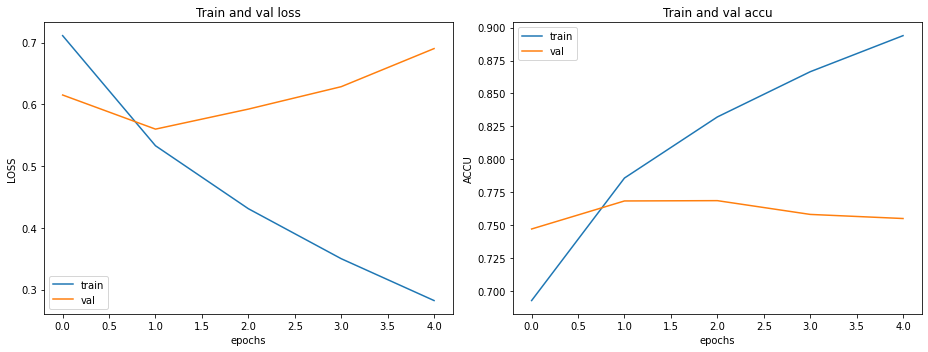

In [0]:
def plot_losses_accuracies(losses, accuracies, width=13, height=5):
    """
    Plot losses and accuracies in each epoch on train and val set
    Args:
        losses -- python dictionary
                    {"train": loss list, "val": loss list}
        accuracies -- python dictionary
                    {"train": accuracies list, "val": accuracies list}
        width -- plot width config
        height -- plot height config
    """         
    plt.figure(figsize=(width, height))    
    results = {"loss": losses, "accu": accuracies}

    idx_plot = 0
    for type_plot, value in results.items():
        plt.subplot(1,2, idx_plot+1)
        plt.plot(value["train"], label="train")
        plt.plot(value["val"], label="val")
        plt.title("Train and val {0}".format(type_plot))
        plt.ylabel("{0}".format(type_plot).upper())
        plt.xlabel("epochs")
        plt.legend()

        idx_plot += 1
    plt.tight_layout()
    plt.show()

plot_losses_accuracies(losses, accuracies)

In [0]:
datasets = {"train": train_iterator, "val": valid_iterator}

In [0]:
vars(LABEL.vocab)

{'freqs': Counter({'NEGATIVE': 12158, 'NEUTRAL': 12156, 'POSITIVE': 12158}),
 'itos': ['NEGATIVE', 'POSITIVE', 'NEUTRAL'],
 'stoi': defaultdict(<function torchtext.vocab._default_unk_index>,
             {'NEGATIVE': 0, 'NEUTRAL': 2, 'POSITIVE': 1}),
 'vectors': None}

2020-06-01 02:17:09,537 : INFO : NumExpr defaulting to 2 threads.


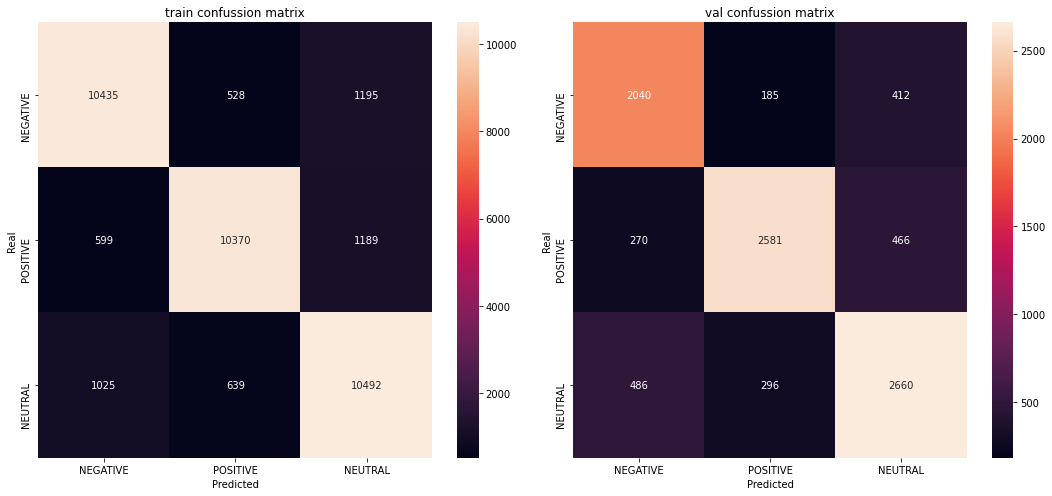

In [0]:
from sklearn.metrics import classification_report, confusion_matrix

def plot_confusion_matrix_training_results(datasets, model, width=13, height=7):
    """
    Plot confusion matrix for every train, test set, using sklearn functions

    Args:
        datasets -- python dictionary 
                        {'train': traindatasets, 'val': valdatasets}
        model -- trained model
        width -- plot configuration width figsize
        height -- plot configuration height figsize
    """
    # Set model to eval
    model.eval()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(width, height))
    cls_report = {}
    for idx_plot, phase in enumerate(['train', 'val']):
        predictions = []
        real = []
        # Get real and predictions
        with torch.no_grad():
            for batch in datasets[phase]:
                text, text_lengths = batch.text
                preds = model(text, text_lengths).squeeze(1)
                _, rounded_preds = torch.max(preds, 1)
                for value, label in zip(rounded_preds, batch.label):
                    predictions.append(value.item())
                    real.append(label.item())


        conf_matrix = confusion_matrix(real, predictions, [0,1,2])
        fig = sns.heatmap(pd.DataFrame(data=conf_matrix, columns=LABEL.vocab.itos, 
                                       index=LABEL.vocab.itos), annot=True, fmt='d', ax=ax[idx_plot])
        
        # save classification report
        cls_report[phase] = classification_report(real, predictions, target_names = LABEL.vocab.itos)
        ax[idx_plot].set_title("{0} confussion matrix".format(phase))
        ax[idx_plot].set_ylabel("Real")
        ax[idx_plot].set_xlabel("Predicted")
    plt.tight_layout()
    plt.show()

    return cls_report

cls_report = plot_confusion_matrix_training_results(datasets, model, width=15)

In [0]:
print(cls_report["train"])

              precision    recall  f1-score   support

    NEGATIVE       0.87      0.86      0.86     12158
    POSITIVE       0.90      0.85      0.88     12158
     NEUTRAL       0.81      0.86      0.84     12156

    accuracy                           0.86     36472
   macro avg       0.86      0.86      0.86     36472
weighted avg       0.86      0.86      0.86     36472



In [0]:
print(cls_report["val"])

              precision    recall  f1-score   support

    NEGATIVE       0.73      0.77      0.75      2637
    POSITIVE       0.84      0.78      0.81      3317
     NEUTRAL       0.75      0.77      0.76      3442

    accuracy                           0.77      9396
   macro avg       0.77      0.77      0.77      9396
weighted avg       0.78      0.77      0.78      9396



In [0]:
model.eval()
predictions = []
real = []
# Get real and predictions
with torch.no_grad():
    for batch in tqdm(test_iterator):
        text, text_lengths = batch.text
        preds = model(text, text_lengths).squeeze(1)
        _, rounded_preds = torch.max(preds, 1)
        for value, label in zip(rounded_preds, batch.label):
            predictions.append(value.item())
            real.append(label.item())

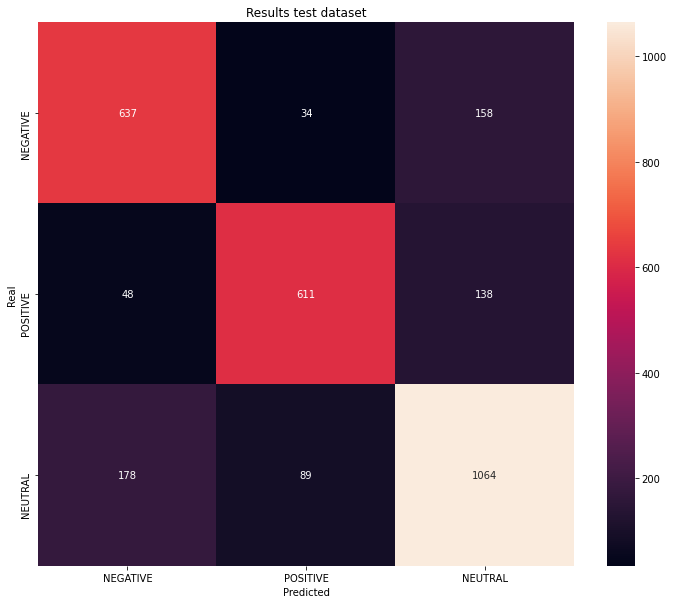

In [0]:
plt.figure(figsize=(12,10))
conf_matrix = confusion_matrix(real, predictions, [0,1,2])
fig = sns.heatmap(pd.DataFrame(data=conf_matrix, columns=LABEL.vocab.itos, index=LABEL.vocab.itos), annot=True, fmt='d')
cls_report["test"] = classification_report(real, predictions, target_names = LABEL.vocab.itos)
fig.plot()
plt.xlabel("Predicted")
plt.ylabel("Real")
plt.title("Results test dataset")
plt.show()

In [0]:
print(cls_report["test"])

              precision    recall  f1-score   support

    NEGATIVE       0.74      0.77      0.75       829
    POSITIVE       0.83      0.77      0.80       797
     NEUTRAL       0.78      0.80      0.79      1331

    accuracy                           0.78      2957
   macro avg       0.78      0.78      0.78      2957
weighted avg       0.78      0.78      0.78      2957



## Proof the model

In [0]:
def predict_sentiment(model, sentence):
    model.eval()
    tokenized = [tok.strip() for tok in tokenizer_tweet(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    with torch.no_grad():
        outputs = model(tensor, length_tensor).squeeze(1)
        _, prediction = torch.max(outputs, 1)
        
    return LABEL.vocab.itos[prediction.item()]

# Make prediction with batch

In [0]:
# Save torchtext datasets
import dill

with open("./model/TEXT.Field", "wb")as f:
     dill.dump(TEXT,f)

with open("./model/LABEL.Field", "wb")as f:
     dill.dump(LABEL,f)

torch.save(model.state_dict(), './model/last_model.pt')

In [0]:
import dill
import torch

# Loading vocab models
with open(os.path.join(DATA_PATH, "model", "TEXT.Field"), 'rb') as f:
  TEXT = dill.load(f)
with open(os.path.join(DATA_PATH, "model", "LABEL.Field"), 'rb') as f:
  LABEL = dill.load(f)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Net(len(TEXT.vocab), 300, 256, 3, 2, True, 0.5, TEXT.vocab.stoi[TEXT.pad_token])
model.load_state_dict(torch.load(os.path.join(DATA_PATH, "model", "last_model.pt"), map_location=device))
model.eval().to(device)

Net(
  (embedding): Embedding(25002, 300, padding_idx=1)
  (rnn): LSTM(300, 256, num_layers=2, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [0]:
tests = test_df.sample(5)
print(tests)

                                                  tweet sentiment
221                              papa francisco gracias  POSITIVE
957   como lo mencionaba anteriormente continuamos c...   NEUTRAL
443                  al paso que vamos así no vas tocar  NEGATIVE
1793  la vida teje su propio equilibrio de ganancias...   NEUTRAL
2305  dos cosas muy bellas sucedieron ayer en el sal...  POSITIVE


In [0]:
tests = tests['tweet']
test_tokenize = [tokenizer_tweet(test) for test in tests]

In [0]:
preprocess_for_model = TEXT.pad(test_tokenize)

print(preprocess_for_model[0])
print(preprocess_for_model[1])

[['papa', 'francisco', 'gracias', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['como', 'lo', 'mencionaba', 'anteriormente', 'continuamos', 'con', 'casos', 'de', 'coronavirus', 'en', 'colombia', 'ratifico', 'también', 'que', 'el', 'es', 'el', 'único', 'vocero', 'oficial', 'que', 'confirmará', 'un', 'caso', 'positivo', 'si', 'esto', 'llegara', 'a', 'suceder', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'], ['al', 'paso', 'que', 'vamos', 'así', 'no', 'vas', 'tocar', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '

In [0]:
# Numeralize tranform to tensors
preprocess_for_model_tensor = TEXT.numericalize(preprocess_for_model, device=device)

In [0]:
preprocess_for_model_tensor[0] # tranformation from vocab to idx, and arr to tensor
                                # las columnas son los tweets bro

tensor([[  903,    26,    24,     3,   101],
        [ 1324,    21,   285,    37,    59],
        [   31,     0,     4,     0,  3867],
        [    1, 20482,   102,    29,     0],
        [    1,  2019,    55,  1268,   317],
        [    1,    10,     9,  7504,     6],
        [    1,   339,   670,     2,     7],
        [    1,     2,  2507,     0,     0],
        [    1,   418,     1,     5,    17],
        [    1,     6,     1,  5427,   341],
        [    1,    43,     1,     0,     2],
        [    1, 17368,     1, 14703, 13462],
        [    1,   115,     1,     4,  6481],
        [    1,     4,     1,    96,     0],
        [    1,     7,     1, 19957,    20],
        [    1,    13,     1,  5427, 21639],
        [    1,     7,     1,     4,   132],
        [    1,   393,     1,     0,   221],
        [    1,  9895,     1,     2,     8],
        [    1,   541,     1,  6304,  1251],
        [    1,     4,     1,     6,   105],
        [    1,     0,     1,    17,    14],
        [ 

In [0]:
preprocess_for_model_tensor[1]

tensor([ 3, 30,  8, 29, 44])

In [0]:
preprocess_for_model_tensor[1].argsort(descending=True)

tensor([4, 1, 3, 2, 0])

In [0]:
preprocess_for_model_tensor[0][:,preprocess_for_model_tensor[1].argsort(descending=True)] # Reordered 

tensor([[  101,    26,     3,    24,   903],
        [   59,    21,    37,   285,  1324],
        [ 3867,     0,     0,     4,    31],
        [    0, 20482,    29,   102,     1],
        [  317,  2019,  1268,    55,     1],
        [    6,    10,  7504,     9,     1],
        [    7,   339,     2,   670,     1],
        [    0,     2,     0,  2507,     1],
        [   17,   418,     5,     1,     1],
        [  341,     6,  5427,     1,     1],
        [    2,    43,     0,     1,     1],
        [13462, 17368, 14703,     1,     1],
        [ 6481,   115,     4,     1,     1],
        [    0,     4,    96,     1,     1],
        [   20,     7, 19957,     1,     1],
        [21639,    13,  5427,     1,     1],
        [  132,     7,     4,     1,     1],
        [  221,   393,     0,     1,     1],
        [    8,  9895,     2,     1,     1],
        [ 1251,   541,  6304,     1,     1],
        [  105,     4,     6,     1,     1],
        [   14,     0,    17,     1,     1],
        [ 

In [0]:
def batch_prediction(model, preprocess_for_model_tensor, tweets_tests):
    """
    Make batch predictions
    Args:
        model -- lstm model
        preprocess_for_model_tensor -- tuple containing the preprocess_tweets and 
                        the lenghts
        tweets -- tweets normales
    """
    model.eval()

    # Sort lengths
    tweets, tweets_lengths = preprocess_for_model_tensor
    idx_sort = tweets_lengths.argsort(descending=True)

    # Make the respective sorts reorded the columns
    tweets_sort = tweets[:, idx_sort]
    
    # Make the respective sorts reorded leghts
    tweets_lengths_sort = tweets_lengths[idx_sort]
    tweets_reorded = np.array(tweets_tests)[idx_sort]

    with torch.no_grad():
        outputs = model(tweets_sort, tweets_lengths_sort)

    _, preds = torch.max(outputs, 1)

    predictions = np.array(LABEL.vocab.itos)[preds]
    return pd.DataFrame((tweet, pred) for tweet, pred in zip(tweets_reorded, predictions))

In [0]:
results = batch_prediction(model, preprocess_for_model_tensor, tests)
results.columns = ['tweet', 'predicted_sentiment']
print(results)

                                               tweet predicted_sentiment
0  dos cosas muy bellas sucedieron ayer en el sal...            POSITIVE
1  como lo mencionaba anteriormente continuamos c...             NEUTRAL
2  la vida teje su propio equilibrio de ganancias...            NEGATIVE
3                 al paso que vamos así no vas tocar            NEGATIVE
4                             papa francisco gracias            POSITIVE


In [0]:
!pip freeze